<a href="https://colab.research.google.com/github/sambethune/causal_learning/blob/master/28_2_%3E06_3_nb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soundgarden or Alice in Chains? (CNN)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!curl -s https://course.fast.ai/setup/colab | bash

from fastai.vision import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Updating fastai...
Done.


Here we will build a model to determine whether a given song belongs to the catalogue of either of two 1990's Seattle bands, Soundgarden and Alice in Chains. While our previous objective was to classify objects that a 'human expert' could easily distinguish between, we are now aiming to see if we are able to extend our functionality to a task such a 'human expert' may find more subtle. We will continue to use a ResNet CNN frame for transfer learning, loading spectrogram images of song portions as our data set. Note we have turned off data transforms as our data set describes a time series.

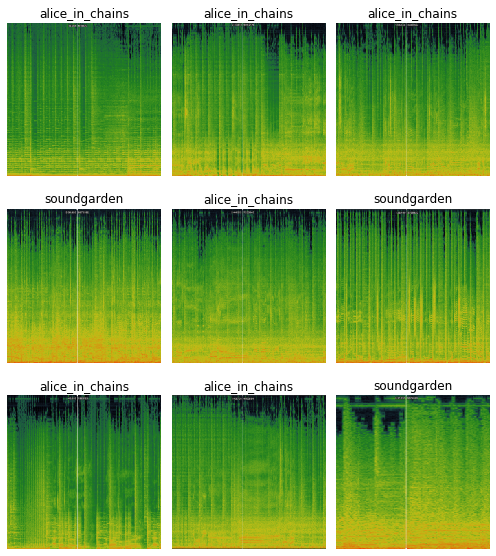

In [2]:
path = Path('/content/drive/My Drive/SCIE3250 Journal/28 2->06 3/data/sound\
garden_or_alice_in_chains')

np.random.seed(2)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, size=224, \
num_workers=4).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,8))

In [3]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [4]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.069756,2.915921,0.400000,00:52
1,0.678720,5.935655,0.400000,00:13
2,0.449206,5.951268,0.400000,00:07
3,0.335552,4.981685,0.400000,00:07


In [0]:
learn.save('stage-1')

Given our metric is constant and high with evidence of overfitting, we proceed to experiment with learning rates in an attempt to ameliorate the problem. However, we suspect that the source of our trouble lies deeper.

In [0]:
learn.load('stage-1')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


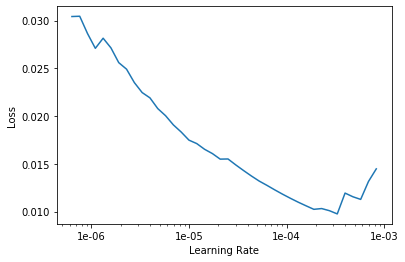

In [7]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.019923,4.101398,0.400000,00:08
1,0.014154,3.165361,0.400000,00:08


Sure enough, things are not working out for us at this stage. Before delving deeper, we try adjusting the image size.

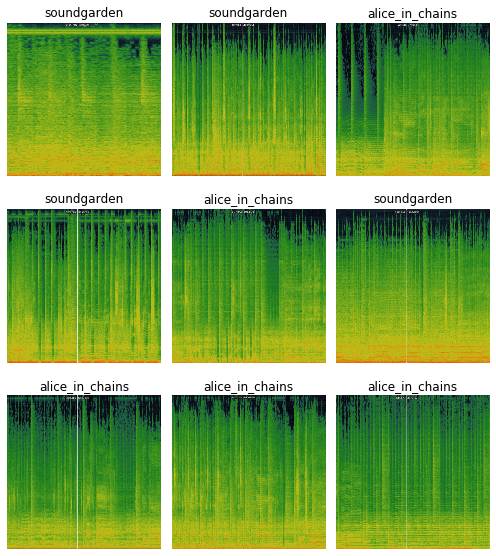

In [9]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, size=500, \
num_workers=4).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,8))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.202130,1.977548,0.400000,00:11
1,0.794475,1.699373,0.375000,00:09
2,0.534886,1.300291,0.300000,00:09
3,0.405239,1.127841,0.300000,00:09


In [0]:
learn.save('stage-1r')

Although we will investigate further later on, for now let us proceed as usual.

In [0]:
learn.load('stage-1r')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


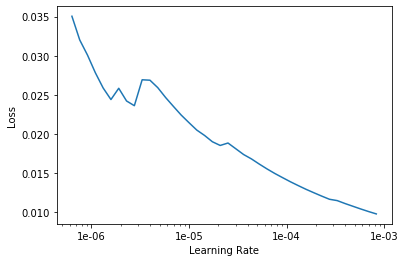

In [14]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, max_lr=slice(5e-06, 5e-05))

epoch,train_loss,valid_loss,error_rate,time
0,0.033067,1.145645,0.275000,00:09
1,0.021498,1.226677,0.250000,00:09


In [0]:
learn.save('stage-1rt')

We begin to suspect that the pretrained ResNet34 body developed on the ImageNet data set might be a hinderance rather than a help here; after all, our data does resemble any sort of physical object. Therefore we try again with transfer learning turned off, retaining our larger image size as this seemed to be beneficial. This time we will skip the phase of guessing our learning rate and instead find it straight away.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [0]:
learn.save('stage-2p')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


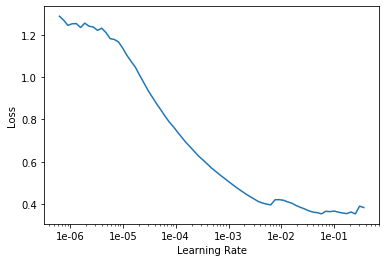

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(30, max_lr=slice(1e-05, 1e-04))

epoch,train_loss,valid_loss,error_rate,time
0,1.483615,28.465296,0.600000,00:09
1,1.374545,3.203126,0.600000,00:09
2,1.355129,0.747775,0.575000,00:09
3,1.255081,0.773279,0.475000,00:09
4,1.145073,0.830317,0.600000,00:09
5,1.054585,0.920720,0.600000,00:09
6,0.959365,0.887703,0.625000,00:09
7,0.853144,0.824490,0.550000,00:09
8,0.752668,0.737455,0.525000,00:09
9,0.670819,0.686692,0.475000,00:09


In [0]:
learn.save('stage-1')

Things seem promising thus far; we will continue to tune our model. Note that there is no need to unfreeze the body at this stage as we are not running a pretrained model.

In [35]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
alice_in_chains,alice_in_chains,alice_in_chains,alice_in_chains,alice_in_chains
Path: /content/drive/My Drive/SCIE3250 Journal/28 2->06 3/data/soundgarden_or_alice_in_chains;

Valid: LabelList (40 items)
x: ImageList
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: CategoryList
soundgarden,alice_in_chains,soundgarden,soundgarden,soundgarden
Path: /content/drive/My Drive/SCIE3250 Journal/28 2->06 3/data/soundgarden_or_alice_in_chains;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, 

In [36]:
learn.fit_one_cycle(20, 1e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.005981,0.421619,0.175000,00:08
1,0.009607,0.413484,0.200000,00:09
2,0.008865,0.417491,0.175000,00:08
3,0.010972,0.413466,0.175000,00:08
4,0.010294,0.432267,0.175000,00:08
5,0.010826,0.432604,0.125000,00:08
6,0.010308,0.425878,0.150000,00:08
7,0.012860,0.440205,0.175000,00:08
8,0.013065,0.451730,0.175000,00:08
9,0.013072,0.451872,0.175000,00:08


In [0]:
learn.save('stage-1r')

While things have improved, we have a way to go to satisfy our metric. To investigate further we take a look at some of our less successful inferences.

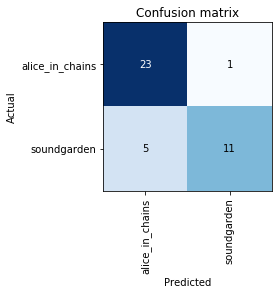

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

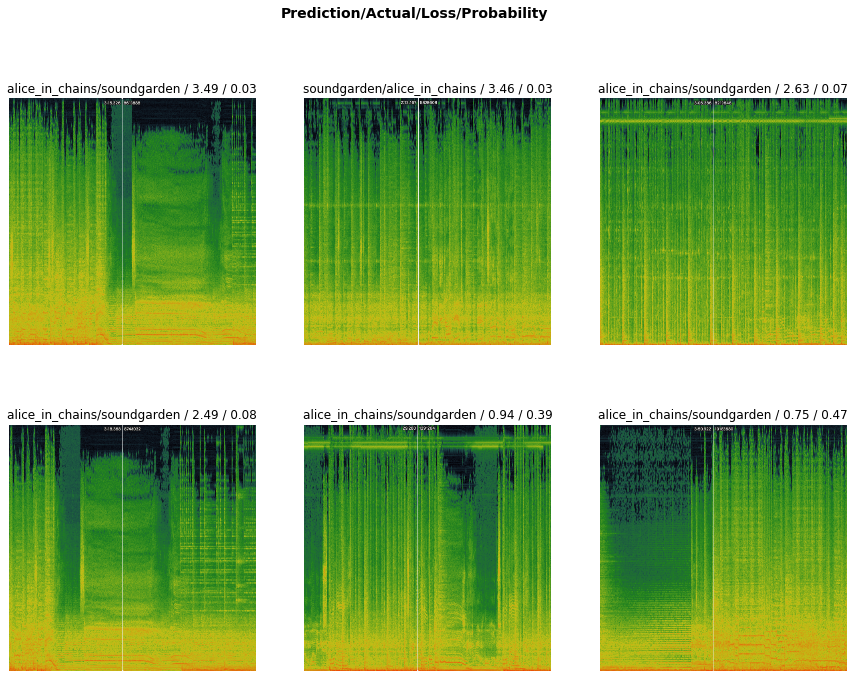

In [45]:
interp.plot_top_losses(6, figsize=(15,11))

We have trouble primarily with confusing Soundgarden songs for Alice in Chains songs, so one option would be to increase the number of Soundgarden songs in our data set and change the metric as before. Looking at the least succesful inferences however, we see that one reason for this may be that our model associates rhythmless pauses almost exclusively with Alice in Chains. While we could enhance our data set or specially construct our test set in order to alleviate this problem, we choose instead to try a different approach to avoid the tedious data acquisition process.